In [2]:
import numpy as np
import pandas as pd

import missingno
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.stem import RSLPStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer


import re
from ftfy import fix_text
from num2words import num2words
from nltk.corpus import stopwords
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24336\2590525310.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load Order and Review

In [3]:
dataset_path = "C:\\Users\\Lenovo\\Downloads\\olist_data\\olist_orders_dataset.csv"
orders = pd.read_csv(dataset_path)
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [4]:
dataset_path = "C:\\Users\\Lenovo\\Downloads\\olist_data\\olist_order_reviews_dataset.csv"
order_review = pd.read_csv(dataset_path)
order_review.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


## Convert to datetime

In [5]:
order_review['review_creation_date'] = pd.to_datetime(order_review['review_creation_date'], format='%Y-%m-%d %H:%M:%S')
order_review['review_answer_timestamp'] = pd.to_datetime(order_review['review_answer_timestamp'], format='%Y-%m-%d %H:%M:%S')
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'], format='%Y-%m-%d %H:%M:%S')


## Merge

In [6]:
order_review = pd.merge(order_review, orders, on='order_id')

In [7]:
order_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   review_id                      99224 non-null  object        
 1   order_id                       99224 non-null  object        
 2   review_score                   99224 non-null  int64         
 3   review_comment_title           11568 non-null  object        
 4   review_comment_message         40977 non-null  object        
 5   review_creation_date           99224 non-null  datetime64[ns]
 6   review_answer_timestamp        99224 non-null  datetime64[ns]
 7   customer_id                    99224 non-null  object        
 8   order_status                   99224 non-null  object        
 9   order_purchase_timestamp       99224 non-null  datetime64[ns]
 10  order_approved_at              99068 non-null  object        
 11  order_delivered

## Null value

In [8]:
order_review.isna().sum()

review_id                            0
order_id                             0
review_score                         0
review_comment_title             87656
review_comment_message           58247
review_creation_date                 0
review_answer_timestamp              0
customer_id                          0
order_status                         0
order_purchase_timestamp             0
order_approved_at                  156
order_delivered_carrier_date      1756
order_delivered_customer_date     2865
order_estimated_delivery_date        0
dtype: int64

In [9]:
order_review['review_comment_title'] = order_review['review_comment_title'].fillna("")
order_review['review_comment_message'] = order_review['review_comment_message'].fillna("")

order_review['have_review_message'] = order_review['review_comment_message'].apply(lambda x: 0 if x == '' else 1)

## Review creation delay time

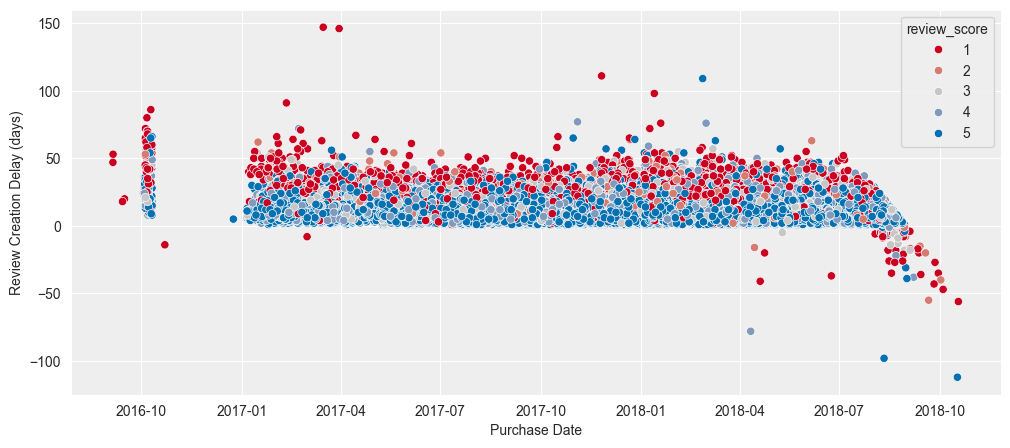

In [10]:
# Define color palette
COLOR_5S = '#0571b0'
COLOR_1S = '#ca0020'
REVIEWS_PALETTE = sns.color_palette((COLOR_1S, '#d57b6f', '#c6c6c6', '#7f9abc', COLOR_5S))

# Set plot style and size
sns.set_style('darkgrid', {'axes.facecolor': '#eeeeee'})
resize_plot = lambda: plt.gcf().set_size_inches(12, 5)

# Calculate review creation delay
order_review['review_creation_delay'] = (order_review['review_creation_date'] - order_review['order_purchase_timestamp']).dt.days

# Plot scatterplot
sns.scatterplot(
    x='order_purchase_timestamp', 
    y='review_creation_delay', 
    hue='review_score', 
    palette=REVIEWS_PALETTE, 
    data=order_review
).set(
    xlabel='Purchase Date', 
    ylabel='Review Creation Delay (days)'
)
resize_plot()

In [11]:
order_review[order_review['review_creation_delay'] < 0]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,have_review_message,review_creation_delay
5293,3415c9f764e478409e8e0660ae816dd2,4d59cc2a2e7bb6c0a851725f5888a9b5,5,,,2018-07-31,2018-07-31 23:11:57,ead83a4f8f7be8c3034b2e98754a6147,canceled,2018-09-06 14:50:07,NaN,NaN,NaT,2018-09-21 00:00:00,0,-38
5503,49f695dffa457eaba90d388a5c37e942,e5215415bb6f76fe3b7cb68103a0d1c0,1,,"PRODUTO NÃO CHEGOU,E JÁ PASSOU O PRAZO DE ENTREGA",2016-10-09,2016-10-11 14:31:29,b6f6cbfc126f1ae6723fe2f9b3751208,canceled,2016-10-22 08:25:27,NaN,NaN,NaT,2016-10-24 00:00:00,1,-14
6857,70475385a0628cbcbf6e0ba534ab69d4,b44b36e6b69be34f58753d3b56d24001,1,Produto errado,Comprei o jogo LEGO Movie (ps3) e recebi LEGO ...,2018-08-08,2018-08-08 20:12:05,a6c9cacb399083fbf6497249c9d3a140,canceled,2018-08-08 14:27:00,NaN,NaN,NaT,2018-08-21 00:00:00,1,-1
8404,08528f70f579f0c830189efc523d2182,7813842ae95e8c497fc0233232ae815a,1,Produto errado,Entrega do produto diferente do solicitado\r\n...,2018-08-03,2018-08-06 00:09:52,040d94f8ba8ca26014bd6f7e8a6e0c0d,canceled,2018-08-17 20:06:36,NaN,NaN,NaT,2018-09-17 00:00:00,1,-15
8486,f1f8696d256889c0fe9962a5d32746e0,392ed9afd714e3c74767d0c4d3e3f477,1,,o produto foi entregue errado eu estou esperad...,2018-08-26,2018-08-28 01:26:38,2823ffda607a2316375088e0d00005ec,canceled,2018-09-29 09:13:03,NaN,NaN,NaT,2018-10-15 00:00:00,1,-35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92768,4548534449b1f572e357211b90724f1b,a2ac6dad85cf8af5b0afb510a240fe8c,1,,quero devolver o produto comprei um veio outro...,2018-08-18,2018-08-19 00:39:54,4c2ec60c29d10c34bd49cb88aa85cfc4,canceled,2018-10-03 18:55:29,NaN,NaN,NaT,2018-10-16 00:00:00,1,-47
93677,b73c8138f998a2caee0d972cee815401,1a5d21f44c73693b9930d0ca33a9d0b1,3,Não recebi o produto,Realizei a compra do kit adipômetro da Sanny e...,2018-08-03,2018-08-03 21:39:03,a21871375ed19fc3f2d8c62fdc75b9dc,canceled,2018-08-16 17:50:14,NaN,NaN,NaT,2018-09-12 00:00:00,1,-14
95741,32415bbf6e341d5d517080a796f79b5c,65fdcb432cb9cfa970e3a3817b39040d,2,Carteira de couro marrom,O produto veio com defeito! Espero que não dem...,2018-08-29,2018-08-31 22:29:09,bb8cc73ebebcd23c9f69c52637229c53,canceled,2018-08-29 08:44:38,NaN,NaN,NaT,2018-09-13 00:00:00,1,-1
98081,23a008b7ae9704e3b656a489d9da4681,9380c59012c11f49c549ef8dffef1367,1,Ruim,Produto veio errado,2018-08-15,2018-08-20 05:05:29,07838708499d3eb9da748cb10b8ddf0a,canceled,2018-08-15 11:05:44,NaN,NaN,NaT,2018-09-21 00:00:00,1,-1


## Distribution of review score

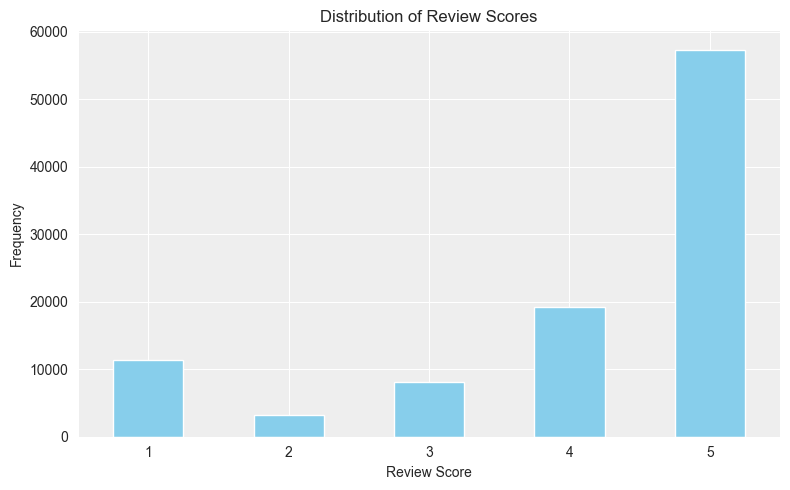

In [12]:
plt.figure(figsize=(8, 5))
order_review['review_score'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.title('Distribution of Review Scores')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Order Status

In [13]:

order_review.groupby('order_status')['order_status'].count()

order_status
approved           2
canceled         609
created            3
delivered      96361
invoiced         313
processing       296
shipped         1043
unavailable      597
Name: order_status, dtype: int64

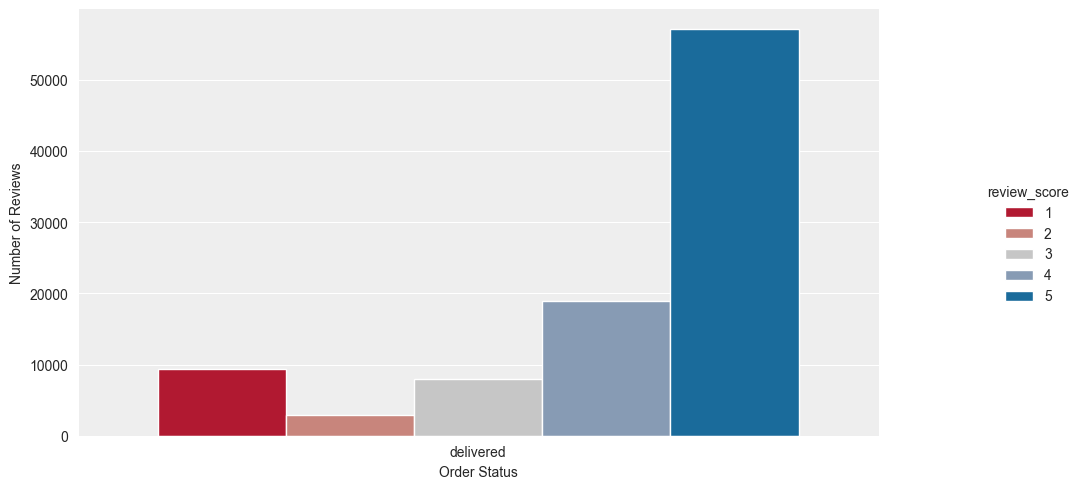

In [14]:
ax = sns.catplot(
    x='order_status',
    kind='count',
    hue='review_score',
    data=order_review[order_review['order_status'] == 'delivered'],
    palette=REVIEWS_PALETTE
).set(xlabel='Order Status', ylabel='Number of Reviews');
resize_plot()

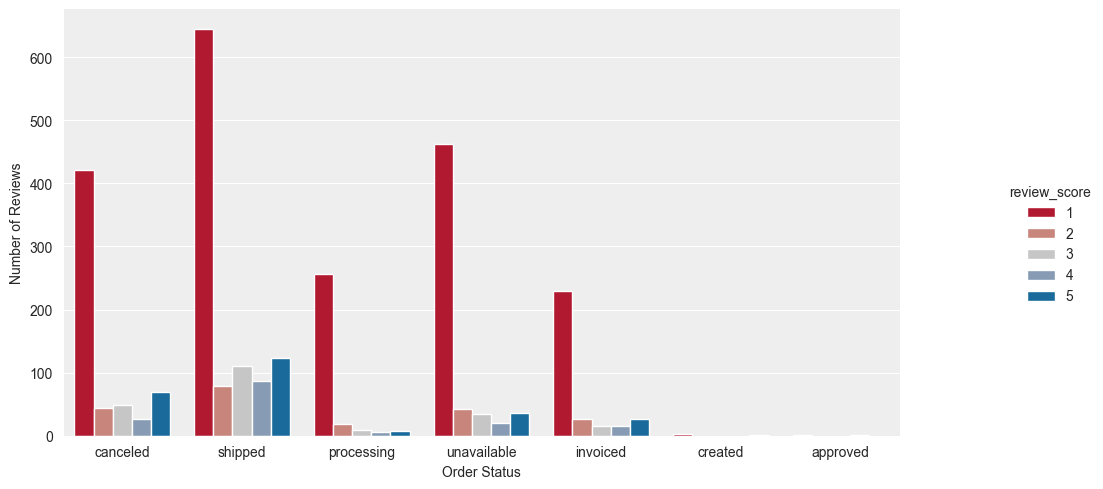

In [15]:
ax = sns.catplot(
    x='order_status',
    kind='count',
    hue='review_score',
    data=order_review[order_review['order_status'] != 'delivered'],
    palette=REVIEWS_PALETTE
).set(xlabel='Order Status', ylabel='Number of Reviews');
resize_plot()

## Text Analysis

In [16]:
order_review.review_comment_title.value_counts(dropna=False)

review_comment_title
                             87656
Recomendo                      423
recomendo                      345
Bom                            293
super recomendo                270
                             ...  
Luminaria sobrepor led 18        1
Não recebi.                      1
produto com lacre violado        1
Atraso Entrega                   1
Foto enganosa                    1
Name: count, Length: 4528, dtype: int64

In [17]:
order_review.review_comment_message.value_counts(dropna=False)

review_comment_message
                                                                                                                                                                                                       58247
Muito bom                                                                                                                                                                                                230
Bom                                                                                                                                                                                                      189
muito bom                                                                                                                                                                                                122
bom                                                                                                                                                          

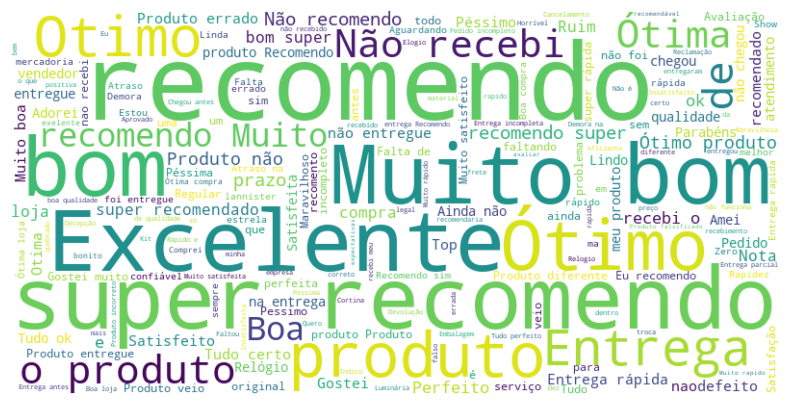

In [18]:
text_combined = ' '.join(order_review['review_comment_title'])

# Create the word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

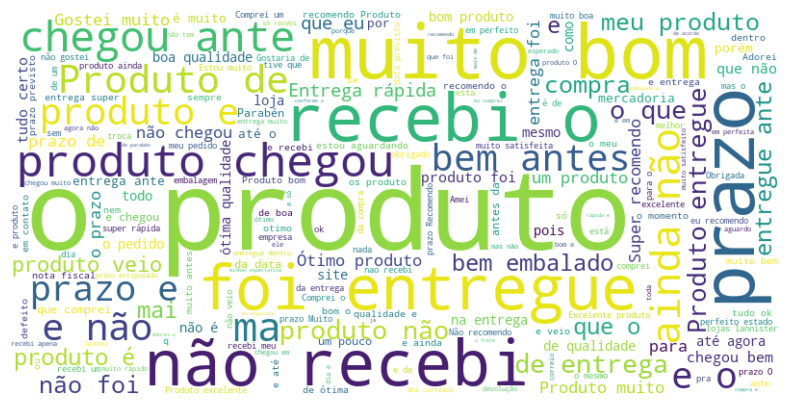

In [19]:
text_combined = ' '.join(order_review['review_comment_message'])

# Create the word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Review Length

In [20]:
order_review['message_length'] = order_review['review_comment_message'].str.len()

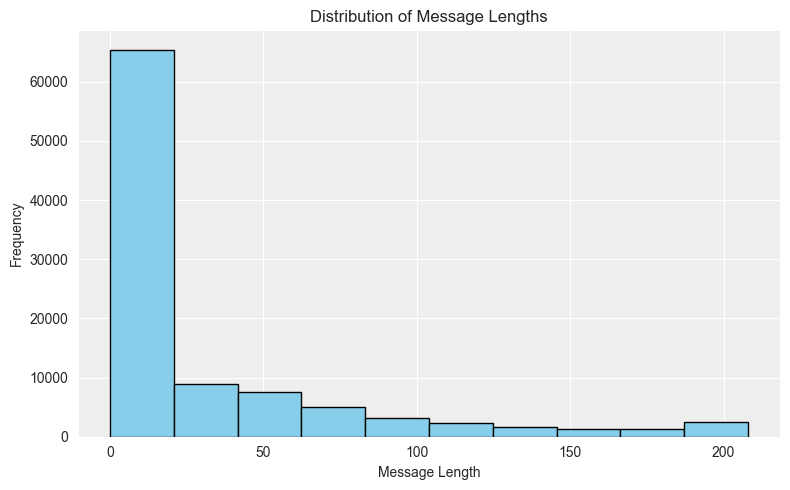

In [21]:
# Visualize the distribution of message lengths using a histogram
plt.figure(figsize=(8, 5))
plt.hist(order_review['message_length'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.title('Distribution of Message Lengths')
plt.tight_layout()
plt.show()

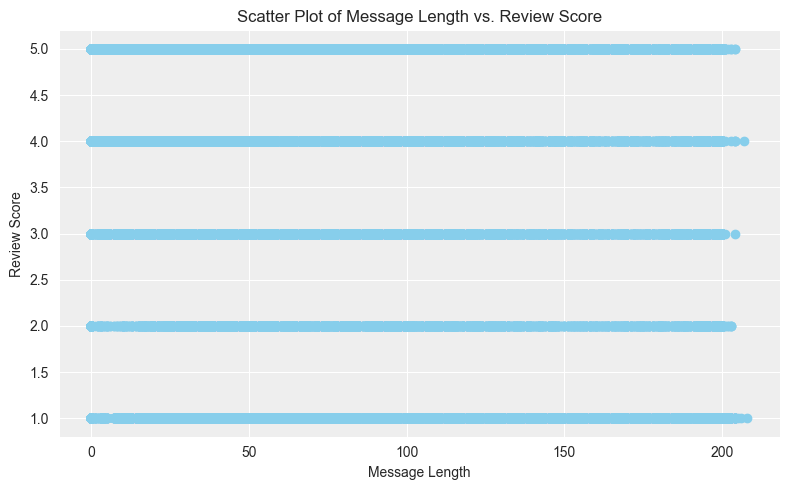

In [22]:
plt.figure(figsize=(8, 5))
plt.scatter(order_review['message_length'], order_review['review_score'], color='skyblue')
plt.xlabel('Message Length')
plt.ylabel('Review Score')
plt.title('Scatter Plot of Message Length vs. Review Score')
plt.tight_layout()
plt.show()

## Clean text data

Breakline and Carriage Return

In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import FunctionTransformer
import re
import pandas as pd

# Define the functions for text preprocessing
def remove_breakline_carriage_return(text):
    return re.sub(r'[\n\r]', '', text)

def re_hiperlinks(text):
    pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return re.sub(pattern, ' link ', text)

def re_dates(text):
    pattern = r'([0-2][0-9]|(3)[0-1])(/|\.)(((0)[0-9])|((1)[0-2]))(/|\.)\d{2,4}'
    return re.sub(pattern, ' date ', text)

def re_money(text):
    pattern = r'[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    return re.sub(pattern, ' dinheiro ', text)

def re_numbers(text):
    return re.sub(r'[0-9]+', ' numero ', text)

def re_negation(text):
    return re.sub(r'([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', text)

def re_special_chars(text):
    return re.sub(r'\W', ' ', text)

def re_whitespaces(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[ \t]+$', '', text)
    return text

def stopwords_removal(text, cached_stopwords=stopwords.words('portuguese')):
    cleaned_text = ' '.join(word.lower() for word in text.split() if word.lower() not in cached_stopwords)
    return cleaned_text

stemmer = RSLPStemmer()

def stem_text(text):
    words = word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

# Define a function to transform a column directly
def preprocess_column(column):
    return (column
            .apply(remove_breakline_carriage_return)
            .apply(re_hiperlinks)
            .apply(re_dates)
            .apply(re_money)
            .apply(re_numbers)
            .apply(re_negation)
            .apply(re_special_chars)
            .apply(re_whitespaces)
            .apply(stopwords_removal)
            .apply(stem_text)
           )

# Building the Pipeline using ColumnTransformer
text_pipeline = Pipeline([
    ('preprocess', FunctionTransformer(preprocess_column, validate=False)),
    ('vectorizer', TfidfVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=stopwords.words('portuguese')))
])

# Apply the pipeline to a specific column in your DataFrame
processed_column = text_pipeline.fit_transform(order_review['review_comment_message'])



In [44]:
tfidf_df = pd.DataFrame(processed_column.toarray(), columns=text_pipeline.named_steps['vectorizer'].get_feature_names_out())
tfidf_df

,abr,acab,ach,acontec,acord,ador,adquir,agor,aguard,aind,...,vei,vem,vend,ver,vez,vier,volt,vou,ótim,únic
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.319411,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99219,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99220,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99221,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99222,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
print(processed_column)

  (3, 109)	0.6527630463602908
  (3, 216)	0.33396788117373855
  (3, 14)	0.37192361416566927
  (3, 30)	0.43472475286323364
  (3, 236)	0.36749567905582686
  (4, 119)	0.42531307983508726
  (4, 278)	0.3141294762432774
  (4, 54)	0.21017346218916716
  (4, 5)	0.31941056189144285
  (4, 150)	0.30591854607737734
  (4, 154)	0.2608928509240671
  (4, 195)	0.6423271974021841
  (9, 294)	0.20065531508345155
  (9, 67)	0.18433843874141068
  (9, 192)	0.17643092580316316
  (9, 48)	0.12442176637749736
  (9, 185)	0.1389152939832757
  (9, 162)	0.46231272657551786
  (9, 261)	0.17946704999827082
  (9, 96)	0.23115636328775893
  (9, 17)	0.7486494070145441
  (12, 31)	0.5207681673150647
  (12, 288)	0.5899138037246873
  (12, 213)	0.6170917436543613
  (15, 103)	0.25108561637611637
  :	:
  (99208, 48)	0.28913655823336476
  (99208, 216)	0.26552182105804717
  (99215, 120)	0.2955446094236305
  (99215, 207)	0.30353817334804406
  (99215, 157)	0.36010178853253005
  (99215, 8)	0.2795779816817363
  (99215, 104)	0.578508207968

In [47]:
order_review = pd.concat([order_review, tfidf_df], axis=1)


In [48]:
order_review.head(5)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,customer_id,order_status,order_purchase_timestamp,...,vei,vem,vend,ver,vez,vier,volt,vou,ótim,únic
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,,,2018-01-18,2018-01-18 21:46:59,41dcb106f807e993532d446263290104,delivered,2018-01-11 15:30:49,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,,,2018-03-10,2018-03-11 03:05:13,8a2e7ef9053dea531e4dc76bd6d853e6,delivered,2018-02-28 12:25:19,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,,,2018-02-17,2018-02-18 14:36:24,e226dfed6544df5b7b87a48208690feb,delivered,2018-02-03 09:56:22,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06,de6dff97e5f1ba84a3cd9a3bc97df5f6,delivered,2017-04-09 17:41:13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53,5986b333ca0d44534a156a52a8e33a83,delivered,2018-02-10 10:59:03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Get the sentiment score

In [49]:
from textblob import TextBlob

def calculate_sentiment(text):
    blob = TextBlob(text)
    sentiment_score = blob.sentiment.polarity  # polarity ranges from -1 (negative) to 1 (positive)
    return sentiment_score

# Apply the calculate_sentiment function to the 'text_column' in the DataFrame
order_review['sentiment_score'] = order_review['review_comment_message'].apply(calculate_sentiment)

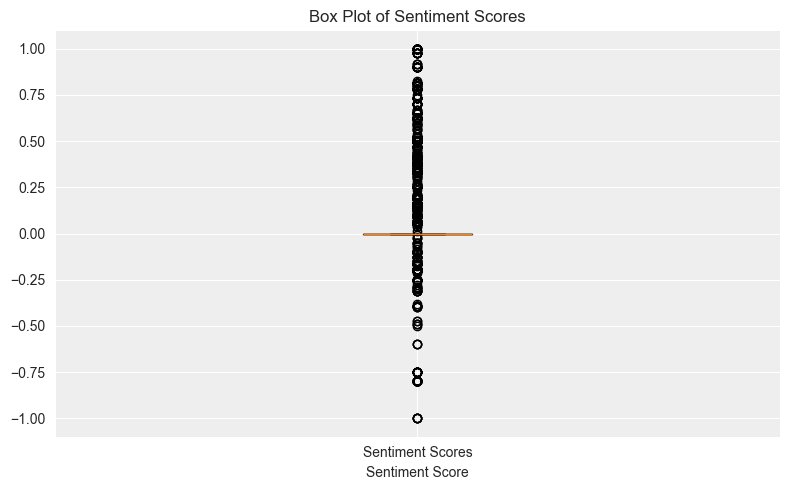

In [50]:
plt.figure(figsize=(8, 5))
plt.boxplot(order_review['sentiment_score'])
plt.xlabel('Sentiment Score')
plt.title('Box Plot of Sentiment Scores')
plt.xticks([1], ['Sentiment Scores'])
plt.tight_layout()
plt.show()

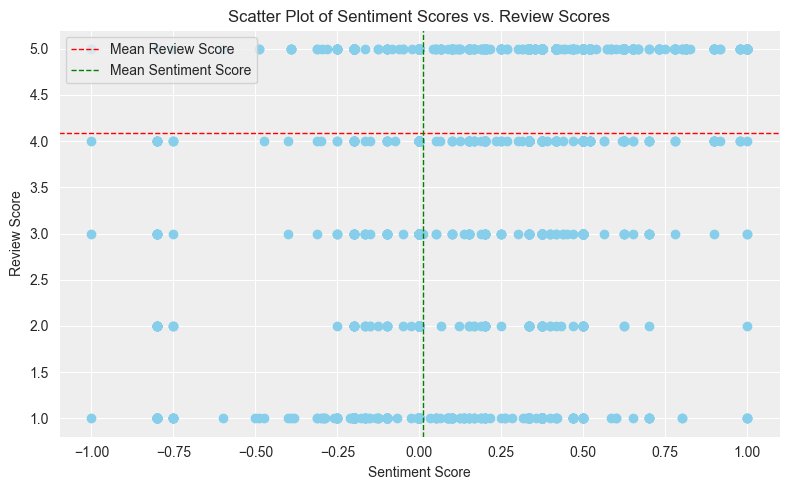

In [51]:
plt.figure(figsize=(8, 5))
plt.scatter(order_review['sentiment_score'], order_review['review_score'], color='skyblue')
plt.xlabel('Sentiment Score')
plt.ylabel('Review Score')
plt.title('Scatter Plot of Sentiment Scores vs. Review Scores')
plt.axhline(order_review['review_score'].mean(), color='red', linestyle='--', linewidth=1, label='Mean Review Score')
plt.axvline(order_review['sentiment_score'].mean(), color='green', linestyle='--', linewidth=1, label='Mean Sentiment Score')
plt.legend()
plt.tight_layout()
plt.show()

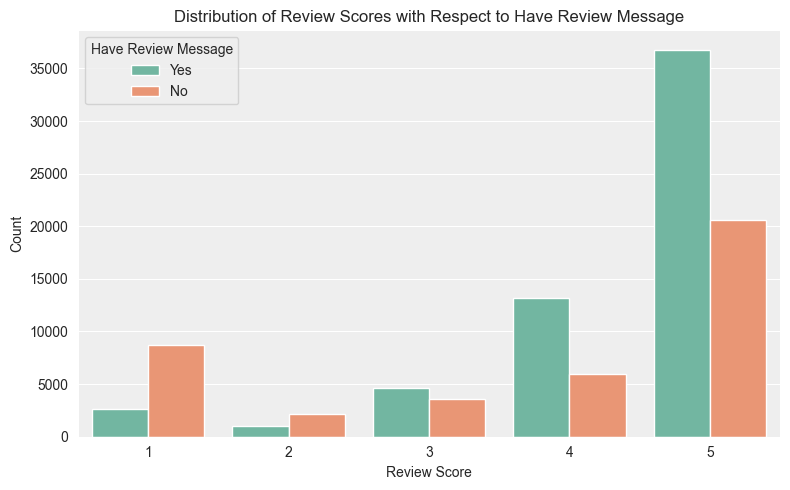

In [52]:
plt.figure(figsize=(8, 5))
sns.countplot(x='review_score', hue='have_review_message', data=order_review, palette='Set2')
plt.xlabel('Review Score')
plt.ylabel('Count')
plt.title('Distribution of Review Scores with Respect to Have Review Message')
plt.legend(title='Have Review Message', labels=['Yes', 'No'])
plt.tight_layout()
plt.show()

#### Higher score tend to have review message

## Because the first sentiment score does not seem to provide good information, try another one

In [53]:
nltk.download('vader_lexicon')

z = order_review.iloc[5]['review_comment_message']
dfrev = pd.DataFrame([['example', {'neg' : 0.0, 'neu' : 1.0, 'pos': 0.0}] , ['example', {'neg' : 0.0, 'neu' : 1.0, 'pos': 0.0}]]
                     , columns = ['review', 'polarity-scores'])
testarr = []
# Vader Sentiment Intensity Analyzer 
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("Wow, NLTK is really shitty!")

order_review['polarity_scores'] = order_review['review_comment_message'].apply(lambda x: sia.polarity_scores(str(x)))
testdb = order_review[['review_score', 'review_comment_message', 'polarity_scores']]
order_review['compound_sentiment_score'] = testdb['polarity_scores'].apply(lambda score_dict: score_dict['compound'])
testdb['compound'] = testdb['polarity_scores'].apply(lambda score_dict: score_dict['compound'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24336\4190887905.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdb['compound'] = testdb['polarity_scores'].apply(lambda score_dict: score_dict['compound'])


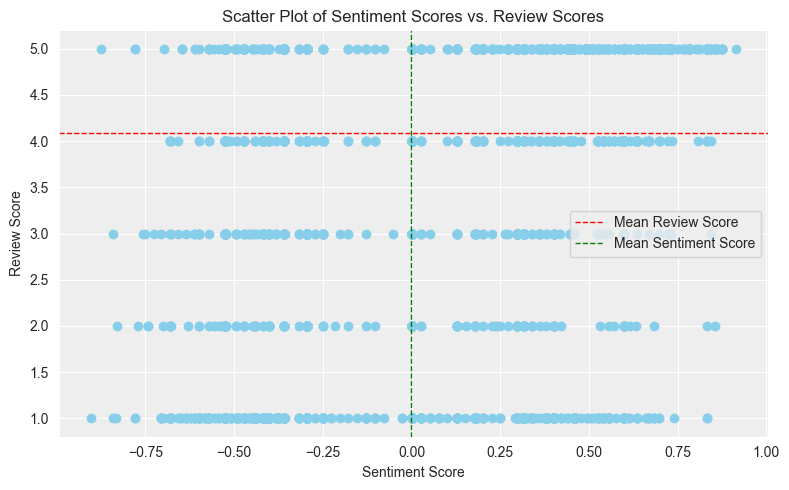

In [54]:
plt.figure(figsize=(8, 5))
plt.scatter(order_review['compound_sentiment_score'], order_review['review_score'], color='skyblue')
plt.xlabel('Sentiment Score')
plt.ylabel('Review Score')
plt.title('Scatter Plot of Sentiment Scores vs. Review Scores')
plt.axhline(order_review['review_score'].mean(), color='red', linestyle='--', linewidth=1, label='Mean Review Score')
plt.axvline(order_review['compound_sentiment_score'].mean(), color='green', linestyle='--', linewidth=1, label='Mean Sentiment Score')
plt.legend()
plt.tight_layout()
plt.show()

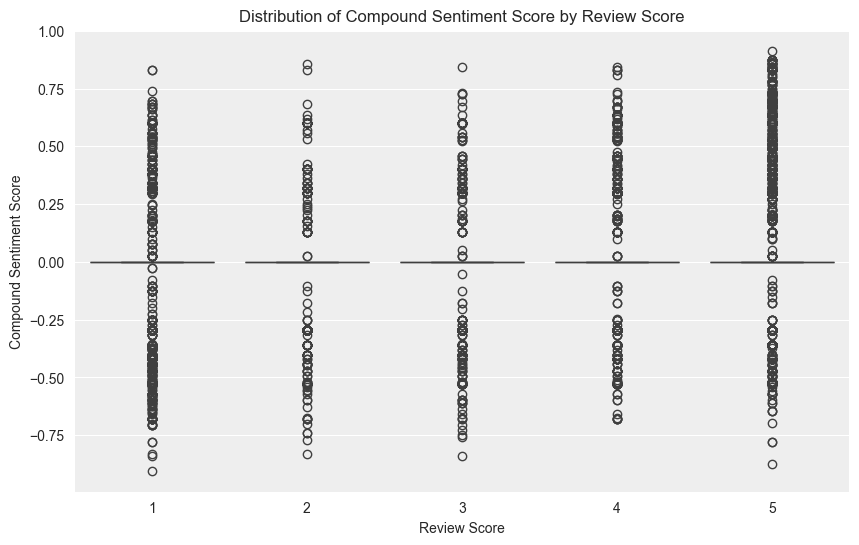

In [55]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='review_score', y='compound_sentiment_score', data=order_review)
plt.title('Distribution of Compound Sentiment Score by Review Score')
plt.xlabel('Review Score')
plt.ylabel('Compound Sentiment Score')
plt.show()

#### Again, no clear pattern can be found.

## Maybe we look into what words contribute to negative and positive score.

#### Top 10 best reviews

In [56]:
y = pd.DataFrame(testdb.sort_values(by= 'compound', ascending = False).head(10)[['review_comment_message', 'compound']])
y.head(10)

,review_comment_message,compound
63315,"Produtos lindos super da hora, chegaram em men...",0.9136
96735,Adoreiii os capachos! super lindos <3 A entreg...,0.8748
58406,"Além do produto ser excelente, fui mt bm atend...",0.8741
91235,Ótimo produto!! Chegou super rápido!!! Ótima q...,0.8741
6607,"O produto é excelente, muito resistente e aten...",0.8741
96774,"Super satisfeita com o produto, o atendimento ...",0.8741
90824,Foi uma compra super tranquila. Super recomend...,0.8741
12279,"Entrega super rápida, a mercadoria chegou muit...",0.8741
35768,"Adorei!!!! Super bem acabada, versátil, pequen...",0.8741
39522,"Entrega super rápida, veio bem antes do prazo ...",0.8650


#### Top 10 worst review

In [57]:
x = pd.DataFrame(testdb.sort_values(by= 'compound', ascending = True).head(10)[['review_comment_message', 'compound']])
x.head(10)

,review_comment_message,compound
98629,Comprei 3 Whey Protein e 1 Hemo Rage no mesmo ...,-0.9039
60968,MAS ACHO QUE TALVEZ NÃO FOI ENTRGUE NO PRAZO!!...,-0.8740
16434,Comprei 3 delas e chegaram no prazo. Ocorre qu...,-0.8402
1904,No site da lannister a data de entrega seria 0...,-0.8402
58277,O produto veio com defeito e esse site criou m...,-0.8317
44831,"FIZ UMA COMPRA DE DUAS LUMINÁRIAS , MEIA LUA ,...",-0.8316
76003,enviaram um email falando que não tinham no e...,-0.7783
72658,Produto estava no site c/ o prazo de 8 dias út...,-0.7783
25955,"Fiz uma compra de dois produtos, um relógio no...",-0.7783
46016,Apesar da paralisação dos caminhoneiros no fin...,-0.7783


#### most popular words in NEGATIVE reviews

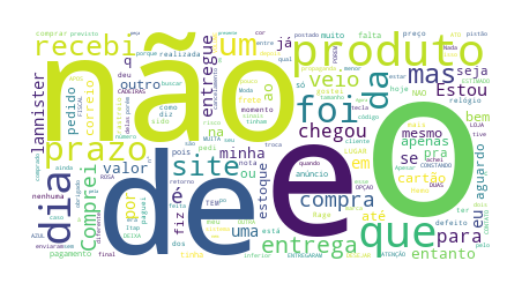

In [58]:
fig, ax = plt.subplots(figsize=(3,1), dpi=300)
bad_reviews = pd.DataFrame(testdb.sort_values(by= 'compound', ascending = True).head(50)[['review_comment_message', 'compound']])
text = " ".join(review for review in bad_reviews.review_comment_message)
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### most popular words in POSITIVE reviews

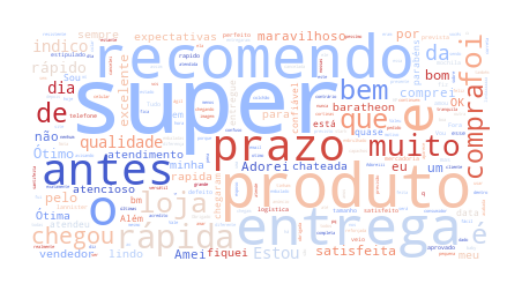

In [59]:
fig, ax = plt.subplots(figsize=(3,1), dpi=300)
good_reviews = pd.DataFrame(testdb.sort_values(by= 'compound', ascending = False).head(50)[['review_comment_message', 'compound']])
text = " ".join(review for review in good_reviews.review_comment_message)
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white', colormap = 'coolwarm').generate(text)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Modeling

In [61]:
order_review.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'customer_id', 'order_status',
       'order_purchase_timestamp',
       ...
       'ver', 'vez', 'vier', 'volt', 'vou', 'ótim', 'únic', 'sentiment_score',
       'polarity_scores', 'compound_sentiment_score'],
      dtype='object', length=320)

In [ ]:
order_review.drop(['review_creation_delay','polarity_scores','compound_sentiment_score', 'review_id', 'order_id', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp','customer_id', 'order_purchase_timestamp','order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'], axis=1, inplace=True)

In [64]:
order_review = pd.get_dummies(order_review, columns=['order_status'], prefix='order_status')

In [74]:
order_review.head(5)

,have_review_message,review_creation_delay,message_length,abr,acab,ach,acontec,acord,ador,adquir,...,sentiment_score,order_status_approved,order_status_canceled,order_status_created,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable,review_sentiment
0,0,6,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,False,False,False,True,False,False,False,False,1
1,0,9,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,False,False,False,True,False,False,False,False,1
2,0,13,0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,False,False,False,True,False,False,False,False,1
3,1,11,37,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,False,False,False,True,False,False,False,False,1
4,1,18,100,0.0,0.0,0.0,0.0,0.0,0.319411,0.0,...,0.0,False,False,False,True,False,False,False,False,1


In [70]:
def transform_review_score(score):
    if 1 <= score <= 3:
        return 0
    else:
        return 1 #'positive'

# Apply the transformation to the review_score column
order_review['review_sentiment'] = order_review['review_score'].apply(lambda x: transform_review_score(x))

In [75]:
order_review.drop(['review_score'], axis=1, inplace=True)

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from category_encoders import CountEncoder
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

random_state =2024

In [77]:
X = order_review.drop('review_sentiment',axis=1)
y = order_review['review_sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state,stratify=y)

In [79]:
random_state = 42  # Set your desired random state for reproducibility

# Initialize XGBClassifier
xgb_classifier = XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric='logloss')

# Train the classifier
xgb_classifier.fit(X_train, y_train)

# Evaluate the classifier
train_score = xgb_classifier.score(X_train, y_train)
test_score = xgb_classifier.score(X_test, y_test)

print(f"Train Accuracy: {train_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")

Train Accuracy: 0.8858
Test Accuracy: 0.8734


In [81]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions on test data
y_pred = xgb_classifier.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.55      0.67      4551
           1       0.88      0.97      0.92     15294

    accuracy                           0.87     19845
   macro avg       0.86      0.76      0.79     19845
weighted avg       0.87      0.87      0.86     19845

Confusion Matrix:
[[ 2520  2031]
 [  482 14812]]


In [ ]:
model = Pipeline(steps=[
    ('train', XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric='logloss')),
])

params = dict(
    train__n_estimators = [100, 200, 300],
    train__learning_rate = [0.1, 0.3, 0.5],
    train__max_depth = [3, 4, 5],
    train__min_child_weight = [1, 5, 10],
    train__gamma = [0.1, 0.3, 0.5])


def train(x_train,y_train,model,params):
    
    gridsearchcv = GridSearchCV(model, params, cv=5, scoring='f1_weighted', verbose=True, n_jobs=-1)
    #gridsearchcv = RandomizedSearchCV(model, params, cv=5, scoring='f1_weighted', verbose=3, n_jobs=-1)
    gridsearchcv.fit(x_train, y_train.values)
    best_model = model.set_params(**gridsearchcv.best_params_).fit(x_train, y_train.values)
    
    return best_model, gridsearchcv.best_params_

best_model, best_params = train(X_train, y_train, model, params)

print("Best Parameters:", best_params)